In [290]:
from quri_parts.core.operator import Operator, pauli_label, PAULI_IDENTITY, PauliLabel
from scipy.optimize import minimize
import numpy as np
from quri_parts.circuit import LinearMappedUnboundParametricQuantumCircuit, Parameter
from quri_parts.core.state import quantum_state
from quri_parts.qulacs.estimator import create_qulacs_vector_estimator
import networkx as nx

# Graph Isomorphism Problem

The Graph Isomorphism (GI) problem is a well-known problem in theoretical computer science and combinatorics. Unlike NP-complete problems, GI is in NP but has not been proven to be either in P or NP-complete, making it a fascinating intermediate problem.  
The goal is to determine whether two given graphs are structurally identical, meaning there exists a bijective mapping between their vertex sets that preserves edge connectivity.

This problem has applications in various fields, including:
* **Chemistry**: Checking whether two molecular graphs represent the same compound.
* **Pattern recognition**: Matching structural patterns in images or graphs.
* **Cryptography**: Designing protocols based on the hardness of GI.

## Problem Definition

Given two undirected graphs **G₁ = (V₁, E₁)** and **G₂ = (V₂, E₂)** with |V₁| = |V₂| = n,  
the goal is to determine whether there exists a bijective mapping  
**π: V₁ → V₂** such that for all vertex pairs (u, v):

$$
(u, v) \in E₁ \iff (\pi(u), \pi(v)) \in E₂
$$

In other words, **G₁** and **G₂** are isomorphic if their adjacency structures match under some vertex relabeling.

### Graph Isomorphism demo  

In [136]:
# Build an example graph
graph1 = {
    'nodes': list(range(3)),
    'edges': [
        (0, 2), (1, 2), (0, 1)
    ]
}

graph2 = {
    'nodes': list(range(3)),
    'edges': [
        (0, 1), (0, 2), (1, 2)
    ]
}

G1 = nx.Graph()
G1.add_nodes_from(graph1['nodes'])
G1.add_edges_from(graph1['edges'])

G2 = nx.Graph()
G2.add_nodes_from(graph2['nodes'])
G2.add_edges_from(graph2['edges'])

nodes = G1.nodes()
num_qubits = G1.number_of_nodes()**2

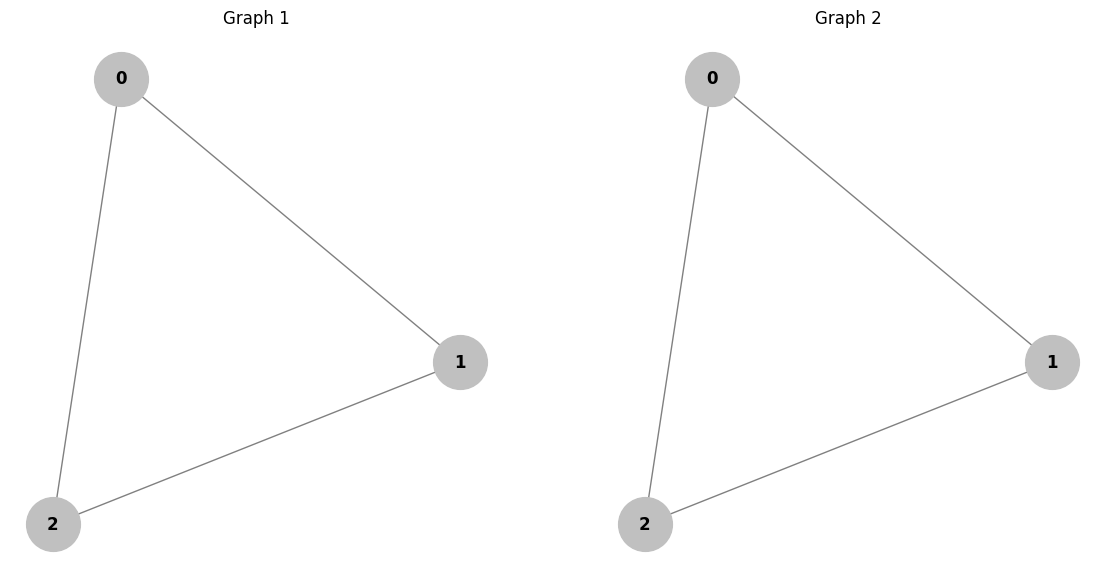

In [137]:
import matplotlib.pyplot as plt
%matplotlib inline

full_graph_color = "#C0C0C0"
pos = nx.spring_layout(G1, seed=42)
# 創建子圖
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

nx.draw(G1, pos, with_labels=True, node_color=full_graph_color, edge_color="gray",
        node_size=1500, font_size=12, font_weight="bold", ax=axes[0])
axes[0].set_title("Graph 1")

nx.draw(G2, pos, with_labels=True, node_color=full_graph_color, edge_color="gray",
        node_size=1500, font_size=12, font_weight="bold", ax=axes[1])
axes[1].set_title("Graph 2")

plt.show()

## QUBO Hamiltonian for Graph Isomorphism

To solve the Graph Isomorphism problem using QUBO, we define a binary matrix of variables $x_{v,i} \in \{0,1\}$ such that:

- $x_{v,i} = 1$ if vertex $v$ in $G_2$ is mapped to vertex $i$ in $G_1$
- $x_{v,i} = 0$ otherwise

This formulation ensures a bijection between the two graphs’ vertex sets and enforces edge consistency.  
The total energy function is composed of two parts: a **bijective constraint Hamiltonian** and an **edge consistency penalty Hamiltonian**.

---

### 1. Bijectivity Constraint:

$$
H_A = A \sum_v \left( 1 - \sum_i x_{v,i} \right)^2
\;+\;
A \sum_i \left( 1 - \sum_v x_{v,i} \right)^2
$$

- The first term ensures that every vertex in $G_2$ maps to **exactly one** vertex in $G_1$.
- The second term ensures that every vertex in $G_1$ receives **exactly one** mapping from $G_2$.
- The parameter **$A > 0$** controls the penalty for violating the bijection.

---

### 2. Edge Consistency Penalty:

$$
H_B = B \sum_{\substack{i j \notin E_1 \\ u v \in E_2}} x_{u,i} x_{v,j}
\;+\;
B \sum_{\substack{i j \in E_1 \\ u v \notin E_2}} x_{u,i} x_{v,j}
$$

- This term penalizes mismatched edges under the proposed mapping.
- The first term penalizes mappings that introduce extra edges not in $G_1$.
- The second term penalizes mappings that miss edges present in $G_1$.
- The parameter **$B > 0$** defines the penalty strength for such invalid mappings.

---

### Final Hamiltonian:

$$
H = H_A + H_B
$$

- If the ground state of $H$ reaches zero ($H = 0$), then the two graphs are isomorphic.
- The number of binary variables (qubits/spins) required is $N^2$, where $N$ is the number of vertices in each graph.



In [426]:
# Define Hamiltonian of Graph isomorphism problem
def qubit_index(u, v, N):
    """
    將 (u, v) 對應到單一 qubit 的索引。
    假設 u, v ∈ {0, 1, ..., N-1}。
    """
    return u*N + v

def add_term(obs_dict: dict, term_str: str, coeff: float) -> None:
    """
    將 'term_str' 對應的 Pauli 標籤累加到 obs_dict 中，係數為 coeff。
    若 term_str 為空字串，表示 identity。
    """
    if term_str=="I":
        key = PAULI_IDENTITY#PauliLabel({int(term_str[1:]):PAULI_IDENTITY})
    else:
        key = pauli_label(term_str)
    if key in obs_dict:
        obs_dict[key] += coeff
    else:
        obs_dict[key] = coeff

def add_x_uv(obs_dict, u, v, coeff, N) -> None:
    """
    加上 coeff * x_{u,v} = coeff * (0.5 + 0.5 Z_{u,v})
    """
    q = qubit_index(u, v, N)
    add_term(obs_dict, f"I", 0.5 * coeff)                 # 0.5 * coeff * I
    add_term(obs_dict, f"Z{q}", -0.5 * coeff)             # 0.5 * coeff * Z_q

def add_x_uv_product(obs_dict, u1, v1, u2, v2, coeff, N) -> None: 
    """
    將 coeff * x_{u1,v1} * x_{u2,v2} 展開為 Pauli 字典，並累加到 obs_dict。
    """
    q1 = qubit_index(u1, v1, N)
    q2 = qubit_index(u2, v2, N)
    # x_{u1,v1} x_{u2,v2} = (0.5 + 0.5Z_{q1}) (0.5 + 0.5Z_{q2})
    #                     = 0.25 + 0.25 Z_{q1} + 0.25 Z_{q2} + 0.25 Z_{q1} Z_{q2}
    # 然後整體再乘以 coeff
    c = 0.25 * coeff
    add_term(obs_dict, f"I", c)               # 0.25 * I
    add_term(obs_dict, f"Z{q1}", -c)          # 0.25 * Z_{q1}
    add_term(obs_dict, f"Z{q2}", -c)          # 0.25 * Z_{q2}
    if q1!=q2:
        add_term(obs_dict, f"Z{q1} Z{q2}", c) # 0.25 * Z_{q1} * Z_{q2}

In [444]:
def build_graph_iso_observable(G1: nx.Graph, G2: nx.Graph, A: float, B: float):
    """
    回傳一個 dict (可用 Operator(...) 包裝) 對應 GI Hamiltonian:
      H = H_A + H_B.
    假設 G1, G2 都有 N 個頂點，編號 0..N-1。
    """
    obs_dict = {}
    try:
        G1.number_of_nodes()==G2.number_of_nodes()
    except:
        raise ValueError("Graphs must have the same number of nodes.")

    N = G1.number_of_nodes()

    # ========== Part 1: H_A ==========
    # (1) 每個 v, 令 sum_u x_{u,v} = 1
    for v in range(N):
        # (1 - sum_u x_{u,v})^2 = 1 - 2 sum_u x_{u,v} + sum_{u1,u2} x_{u1,v} x_{u2,v}
        # 其中 x_{u,v}^2 = x_{u,v}, 但我們直接用 u1,u2 全遍歷，u1==u2 時一樣
        # 乘上 A
        add_term(obs_dict, f"I", A)  # 來自 "1" 的項
        for u in range(N):
            # -2 * x_{u,v}
            add_x_uv(obs_dict, u, v, coeff=-2*A, N=N)
        # x_{u1,v} x_{u2,v}
        for u1 in range(N):
            for u2 in range(N):
                add_x_uv_product(obs_dict, u1, v, u2, v, coeff=A, N=N)

    # (2) 每個 u, 令 sum_v x_{u,v} = 1
    for u in range(N):
        add_term(obs_dict, f"I", A)
        for v in range(N):
            add_x_uv(obs_dict, u, v, coeff=-2*A, N=N)
        for v1 in range(N):
            for v2 in range(N):
                add_x_uv_product(obs_dict, u, v1, u, v2, coeff=A, N=N)

    # ========== Part 2: H_B ==========
    # 若 (u1,u2) ∈ E1, (v1,v2) 不在 E2, 就加 B * x_{u1,v1} x_{u2,v2}
    # 若 (u1,u2) 不在 E1, (v1,v2) ∈ E2, 也加 B * x_{u1,v1} x_{u2,v2}
    # 注意無向邊 => 只考慮 u1 < u2 / v1 < v2 來避免重複
    E1 = set()
    for (u1,u2) in G1.edges():
        if u1<u2: u1,u2 = u2,u1
        E1.add((u1,u2))
    E2 = set()
    for (v1,v2) in G2.edges():
        if v1<v2: v1,v2 = v2,v1
        E2.add((v1,v2))
    
    for u1 in range(N):
        for u2 in range(u1+1, N):
            inE1 = ((u2,u1) in E1)
            for v1 in range(N):
                for v2 in range(v1+1, N):
                    inE2 = ((v2,v1) in E2)
                    # 如果 "在 E1 但不在 E2" 或 "不在 E1 但在 E2"
                    if inE1 != inE2:
                        # 懲罰 x_{u1,v1} x_{u2,v2}
                        add_x_uv_product(obs_dict, u1,v1, u2,v2, B, N=N)

    return Operator(obs_dict)
cost_observable = build_graph_iso_observable(G1=G1, G2=G2, A=1, B=0)

In [451]:
def translate_operator_to_circuit(operator: Operator,
                                  circuit: LinearMappedUnboundParametricQuantumCircuit,
                                  gamma_idx: int) -> None:
  """
  將一個 Operator（成本 Hamiltonian）轉換成對應的參數化量子電路，實現 U_C(γ)=exp(-iγH_C)。
  
  參數:
    operator: quri_parts.core.operator.Operator，內部以 dict 儲存各項 (鍵為 pauli_label, 值為係數)
    circuit: LinearMappedUnboundParametricQuantumCircuit，已建立好且擁有 num_qubits 個 qubit
    gamma_parameter_name: 用來綁定參數的名字，例如 "gamma_0"
  """
  gamma = circuit.add_parameter(f"gamma_{gamma_idx}")
  for pauli in operator:
    # 如果是 identity 項（全 I），我們可以忽略（全局相位不影響結果)
    if pauli==PAULI_IDENTITY:
      continue
    circuit.add_ParametricPauliRotation_gate(*pauli.index_and_pauli_id_list, {gamma: -2})


In [452]:
# num_qubits = G1.number_of_nodes()**2

# circuit = LinearMappedUnboundParametricQuantumCircuit(num_qubits)
# translate_operator_to_circuit(cost_observable, circuit=circuit)

In [453]:
num_qubits = G1.number_of_nodes()**2

def add_U_C(circuit: LinearMappedUnboundParametricQuantumCircuit, gamma_idx) -> None:
    return translate_operator_to_circuit(cost_observable, circuit=circuit, gamma_idx=gamma_idx)

def add_U_X(circuit: LinearMappedUnboundParametricQuantumCircuit, beta_idx) -> None:
    beta = circuit.add_parameter(f"beta_{beta_idx}")
    for i in range(num_qubits):
        circuit.add_ParametricRX_gate(i, {beta: -2})
    return circuit

estimator = create_qulacs_vector_estimator()

depth=5
def QAOA_output(x: list[float]) -> float:
    circuit = LinearMappedUnboundParametricQuantumCircuit(num_qubits)
    ## to create superposition, apply Hadamard gate
    for i in range(num_qubits):
        circuit.add_H_gate(i)

    ## apply  U_C, U_X
    for i in range(depth):
        add_U_C(circuit, i)
        add_U_X(circuit, i)

    bound_circuit = circuit.bind_parameters(x)
    
    # prepare |beta, gamma>
    state = quantum_state(num_qubits, circuit=bound_circuit)
    return estimator(cost_observable, state).value.real

x0 = np.array( [0.1 for _ in range(2*depth)])

## minimize with scipy.minimize
result = minimize(QAOA_output, x0, options={'maxiter':1000}, method='powell')

print("QAOA Cost:", result.fun) # value after optimization
print("Optimized Parameter:", result.x) # (beta, gamma) after optimization

QAOA Cost: -3.6902206715962524
Optimized Parameter: [ 2.66512424 -1.56473186  0.68921258 -2.88832293 -0.37430344  0.1947793
 -0.13595037  0.16928895 -0.43686475 -0.24219219]


In [454]:
from quri_parts.qulacs.simulator import evaluate_state_to_vector
# prepare |beta, gamma> using optimized best, gamma

circuit = LinearMappedUnboundParametricQuantumCircuit(num_qubits)
## to create superposition, apply Hadamard gate (Initialization)
for i in range(num_qubits):
    circuit.add_H_gate(i)

##apply  U_C, U_X
for i in range(depth):
    add_U_C(circuit, i)
    add_U_X(circuit, i)

bound_circuit = circuit.bind_parameters(result.x)
## prepare |beta, gamma>
state = quantum_state(num_qubits, circuit=bound_circuit)

## Find the of each component of the state vector = probability distribution when observed in the z direction. (Square of the absolute value observation probability)
probs = np.abs(evaluate_state_to_vector(state).vector)**2
print(probs*100)

[3.86962615e-03 4.63583054e-02 4.63583054e-02 3.93858948e-02
 4.63583054e-02 3.93858948e-02 3.93858948e-02 3.33046633e-02
 4.63583054e-02 3.93858948e-02 2.97457069e-01 5.00980687e-02
 2.97457069e-01 5.00980687e-02 2.17476059e-01 2.62908505e-02
 4.63583054e-02 2.97457069e-01 3.93858948e-02 5.00980687e-02
 2.97457069e-01 2.17476059e-01 5.00980687e-02 2.62908505e-02
 3.93858948e-02 5.00980687e-02 5.00980687e-02 1.01610283e-02
 2.17476059e-01 2.08992863e-02 2.08992863e-02 7.65066414e-03
 4.63583054e-02 2.97457069e-01 2.97457069e-01 2.17476059e-01
 3.93858948e-02 5.00980687e-02 5.00980687e-02 2.62908505e-02
 3.93858948e-02 5.00980687e-02 2.17476059e-01 2.08992863e-02
 5.00980687e-02 1.01610283e-02 2.08992863e-02 7.65066414e-03
 3.93858948e-02 2.17476059e-01 5.00980687e-02 2.08992863e-02
 5.00980687e-02 2.08992863e-02 1.01610283e-02 7.65066414e-03
 3.33046633e-02 2.62908505e-02 2.62908505e-02 7.65066414e-03
 2.62908505e-02 7.65066414e-03 7.65066414e-03 5.36777889e-03
 4.63583054e-02 3.938589

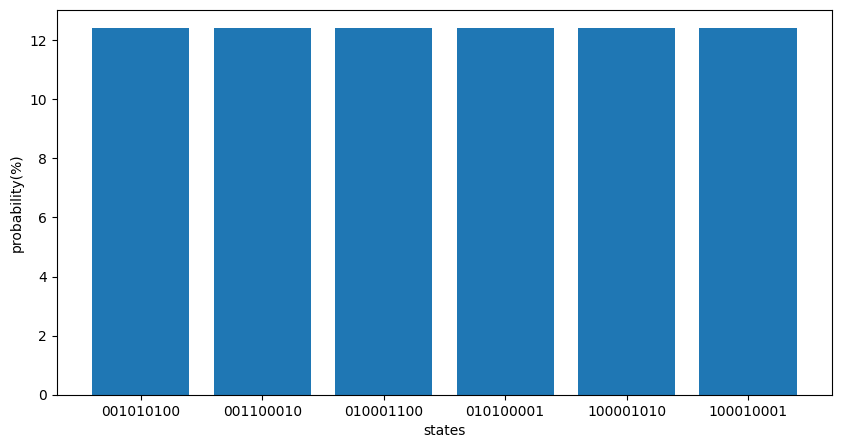

In [455]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

threshold = 0.05  # Only print values whose probability above threshold
indices = np.where(probs > threshold)[0]
z_basis_filtered = [format(i, "b").zfill(num_qubits) for i in indices]
probs_filtered = probs[indices]

plt.figure(figsize=(10, 5))
plt.xlabel("states")
plt.ylabel("probability(%)")
plt.bar(z_basis_filtered, probs_filtered * 100)
plt.show()